In [1]:
import jax
jax.config.update("jax_platform_name", "cpu")
from foundry.util.runtime import setup
setup()
import matplotlib.pyplot as plt
from policy_eval.lower_bounds import stable
from foundry.util.registry import Registry

registry = Registry()

stable.register_datasets(registry)

data = registry.create("lower_bound/stable/1")
env = data.create_env()
train_data, _ = data.split("train").as_pytree()
test_data, _ = data.split("test").as_pytree()
test_x0s = test_data.state[:,0]

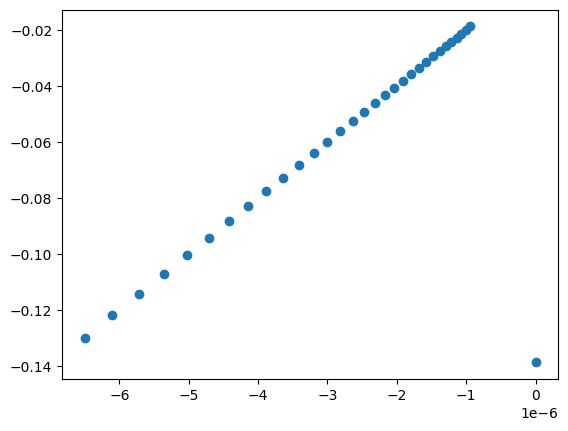

In [2]:
states = train_data.state[4, :, :2]
plt.plot(states[:, 0], states[:, 1], "o")

In [13]:
from foundry.policy import PolicyInput, PolicyOutput
from foundry.core import tree
import foundry.core as F
import foundry.policy
import foundry.numpy as npx

def baseline_policy(x: PolicyInput) -> PolicyOutput:
    action = 0.01*jax.random.normal(x.rng_key, x.state.shape)/npx.sqrt(x.state.shape[0])
    return PolicyOutput(action=action)

def eval(x0):
    rollout = foundry.policy.rollout(env.step, x0, baseline_policy, length=50, policy_rng_key=jax.random.key(42), last_action=True)
    pre_states, actions, post_states = (
        tree.map(lambda x: x[:-1], rollout.states),
        tree.map(lambda x: x[:-1], rollout.actions),
        tree.map(lambda x: x[1:], rollout.states)
    )
    rewards = -F.vmap(env.reward)(
        pre_states, actions, post_states
    )
    return rewards
baseline_rewards = jax.vmap(eval)(test_x0s)

In [4]:
import wandb
import pandas as pd
api = wandb.Api()
sweep = api.sweep("dpfrommer-projects/lower_bound/7rxi4mfv")

data = []
for run in sweep.runs:
    if run.state == "finished":
        summary = run.summary
        if run.config["dp.replica_noise"] > 0 and run.config["method"] != "diffusion_policy":
            continue
        else:
            method = run.config["method"]
            method = f"{method}{' (replica)' if run.config['dp.replica_noise'] > 0. else ''}"
        data.append({
            "method": method,
            "replica_noise": run.config["dp.replica_noise"],
            "trajectories": run.config["train_trajectories"],
            "action_length": run.config["action_length"],
            "timesteps": run.config["timesteps"],
            "reward_mean": summary["reward_mean"],
            "reward_std": summary["reward_std"],
            "seed": run.config["seed"]
        })
data = pd.DataFrame(data)
# data = data[data.timesteps < 10]
# data = data[data.replica_noise == 0.]
data

,method,replica_noise,trajectories,action_length,timesteps,reward_mean,reward_std,seed
0,diffusion_policy (replica),0.1,2048,1,32,-3.265439,0.723079,47
1,diffusion_policy (replica),0.1,2048,1,28,-2.542897,0.573797,47
2,diffusion_policy (replica),0.1,2048,1,24,-1.884837,0.440267,47
3,diffusion_policy (replica),0.1,2048,1,20,-1.303178,0.323642,47
4,diffusion_policy (replica),0.1,2048,1,16,-0.810895,0.225648,47
...,...,...,...,...,...,...,...,...
157,bc,0.0,2048,1,16,-0.041093,0.037487,42
158,bc,0.0,2048,1,12,-0.036742,0.039249,42
159,bc,0.0,2048,1,8,-0.029822,0.037451,42
160,bc,0.0,2048,1,4,-0.014821,0.021294,42


In [5]:
data = data.groupby(["method", "replica_noise", "trajectories", "action_length", "timesteps"]).mean().reset_index()
data

,method,replica_noise,trajectories,action_length,timesteps,reward_mean,reward_std,seed
0,bc,0.0,2048,1,2,-0.002952,0.005133,44.5
1,bc,0.0,2048,1,4,-0.015825,0.017993,44.5
2,bc,0.0,2048,1,8,-0.059256,0.030446,44.5
3,bc,0.0,2048,1,12,-0.103000,0.041243,44.5
4,bc,0.0,2048,1,16,-0.151306,0.049420,44.5
5,bc,0.0,2048,1,20,-0.193373,0.052623,44.5
6,bc,0.0,2048,1,24,-0.241200,0.063414,44.5
7,bc,0.0,2048,1,28,-0.297027,0.071227,44.5
8,bc,0.0,2048,1,32,-0.342767,0.073186,44.5
9,diffusion_policy,0.0,2048,1,2,-0.002952,0.005134,44.5


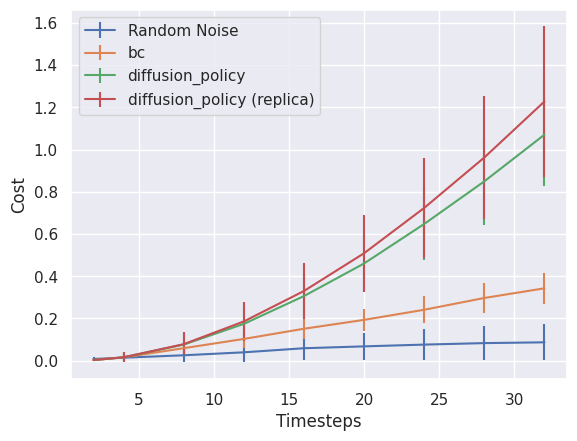

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

baseline = npx.array([(T, npx.mean(npx.max(baseline_rewards[:, :T], axis=-1)), npx.std(npx.max(baseline_rewards[:, :T], axis=-1))) for T in sorted(data.timesteps.unique())])
plt.errorbar(
    baseline[:, 0], baseline[:, 1], yerr=baseline[:,2], label="Random Noise"
)
# plt.plot(
#     baseline[:, 0], baseline[:, 1], label="Random Noise"
# )

colors = ["red", "blue", "green"]
styles = ["-", "--", "-.", ":"]
method_map = {
    "bc": "BC",
    "diffusion_policy": "Diffusion"
}
sub_data = data[(data.trajectories == 2048) & (data.action_length == 1)]
for (method, method_color) in zip(sub_data.method.unique(), colors):
    method_data = sub_data[sub_data.method == method]
    plt.errorbar(
        method_data.timesteps, 
        -method_data.reward_mean, 
        yerr=method_data.reward_std, 
        label=f"{method}"
    )
    # for (N, N_style) in zip(method_data.trajectories.unique(), styles):
    #     N_data = method_data[method_data.trajectories == N]
        # plt.plot(
        #     N_data.timesteps, 
        #     -N_data.reward_mean, 
        #     label=f"{method_map[method]} N={N}",
        #     color=method_color,
        #     linestyle=N_style
        # )
plt.xlabel("Timesteps")
plt.ylabel("Cost")
plt.yscale("log")
plt.legend()
plt.show()

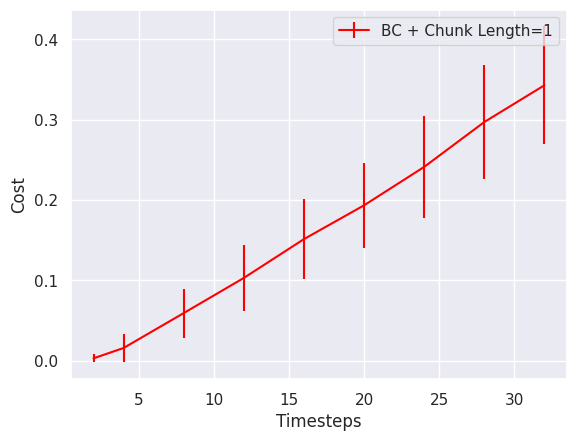

In [7]:
import matplotlib.pyplot as plt

sub_data = data[(data.trajectories == 2048) & (data.method == "bc")]
colors = ["red", "blue", "green", "purple", "orange", "brown"]
for (chunk_length, color) in zip(sub_data.action_length.unique(), colors):
    chunk_data = sub_data[(sub_data.action_length == chunk_length) & (sub_data.trajectories == 2048)]
    plt.errorbar(
        chunk_data.timesteps, 
        -chunk_data.reward_mean, 
        yerr=chunk_data.reward_std,
        label=f"BC + Chunk Length={chunk_length}",
        color=color
    )
plt.xlabel("Timesteps")
plt.ylabel("Cost")
plt.legend()
plt.show()

In [8]:
api.run("")

CommError: cannot access local variable 'id' where it is not associated with a value